In [6]:
import os
from typing import Annotated, List, Dict, Any, Literal
from typing_extensions import TypedDict
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_ollama import ChatOllama
from langchain_ollama import OllamaEmbeddings
from langchain_chroma import Chroma
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
import hashlib

In [7]:
llm = ChatOllama(model="qwen3:4b", temperature=0) 
embeddings = OllamaEmbeddings(model="nomic-embed-text:v1.5")


In [8]:
class AgentState(TypedDict):
    messages: Annotated[List[Any], "Messages in the conversation"]
    next_action: Literal["generate", "reflect", "retrieve", "generate_with_context", "end"]
    retrieved_context: str
    reflection_score: float
    pdf_path: str

In [9]:
def generation_node(state: AgentState) -> Dict[str, Any]:
    """Generate initial response without retrieval"""
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are an AI assistant. Answer the following question to the best of your ability. If you're unsure or don't have enough information, just say so."),
        ("user", "{question}")
    ])
    
    chain = prompt | llm | StrOutputParser()
    question = state["messages"][-1].content
    initial_response = chain.invoke({"question": question})
    
    return {
        "messages": state["messages"] + [AIMessage(content=initial_response)],
        "next_action": "reflect"
    }


In [10]:
def reflection_node(state: AgentState) -> Dict[str, Any]:
    """Evaluate the quality of the generated response"""
    prompt = ChatPromptTemplate.from_messages([
        ("system", "Evaluate the quality of the following response to the question. Rate it on a scale of 1-10 where: 1-3: Poor quality, factually incorrect, or irrelevant; 4-6: Adequate but lacking detail or with potential issues; 7-10: Good quality, accurate, and comprehensive"),
        ("user", "Question: {question}\nResponse: {response}\n\nProvide only the numerical score (1-10):")
    ])
    
    chain = prompt | llm | StrOutputParser()
    question = state["messages"][-1].content
    # Get the last AI message (the generated response)
    response = [m for m in state["messages"] if isinstance(m, AIMessage)][-1].content
    
    score_text = chain.invoke({"question": question, "response": response})
    try:
        score = float(score_text.strip())
    except ValueError:
        # If parsing fails, default to a low score
        score = 3.0
    
    next_action = "retrieve" if score < 7.0 else "end"
    
    return {
        "reflection_score": score,
        "next_action": next_action
    }

In [11]:
def retrieval_node(state: AgentState) -> Dict[str, Any]:
    """Read PDF and retrieve relevant information using Chroma DB"""
    pdf_path = state.get("pdf_path", "")
    
    if not pdf_path or not os.path.exists(pdf_path):
        return {
            "retrieved_context": "No PDF provided or file not found.",
            "next_action": "generate_with_context"
        }
    
    # Create a unique collection name based on PDF path
    collection_name = hashlib.md5(pdf_path.encode()).hexdigest()[:12]
    
    # Check if we already have embeddings for this PDF
    try:
        # Try to load existing collection
        vectorstore = Chroma(
            collection_name=collection_name,
            embedding_function=embeddings,
            persist_directory="./chroma_db"
        )
        # Test if collection has data
        if vectorstore._collection.count() == 0:
            raise Exception("Empty collection")
    except:
        # Load and process PDF if collection doesn't exist or is empty
        loader = PyPDFLoader(pdf_path)
        documents = loader.load()
        
        # Split documents into chunks
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=1000,
            chunk_overlap=200
        )
        docs = text_splitter.split_documents(documents)
        
        # Create vectorstore with documents
        vectorstore = Chroma.from_documents(
            documents=docs,
            embedding=embeddings,
            collection_name=collection_name,
            persist_directory="./chroma_db"
        )
    
    # Perform similarity search
    question = state["messages"][-1].content
    retriever = vectorstore.as_retriever(search_kwargs={"k": 4})
    retrieved_docs = retriever.invoke(question)
    
    # Combine retrieved content
    context = "\n\n".join([doc.page_content for doc in retrieved_docs])
    
    return {
        "retrieved_context": context,
        "next_action": "generate_with_context"
    }

In [12]:
def generation_with_context_node(state: AgentState) -> Dict[str, Any]:
    """Generate final response using retrieved context"""
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are an AI assistant. Use the following context to answer the question. If the context doesn't contain relevant information, say so."),
        ("user", "Context: {context}\n\nQuestion: {question}")
    ])
    
    chain = prompt | llm | StrOutputParser()
    question = state["messages"][-1].content
    context = state["retrieved_context"]
    
    final_response = chain.invoke({
        "context": context,
        "question": question
    })
    
    return {
        "messages": state["messages"] + [AIMessage(content=final_response)],
        "next_action": "end"
    }


In [13]:
def router(state: AgentState) -> str:
    """Determine which node to execute next"""
    return state["next_action"]


In [14]:
from langgraph.graph import StateGraph, END, START

builder = StateGraph(AgentState)

# Add nodes
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("retrieve", retrieval_node)
builder.add_node("generate_with_context", generation_with_context_node)

# Add edges
builder.add_edge(START, "generate")
builder.add_edge("generate", "reflect")
builder.add_conditional_edges(
    "reflect",
    router,
    {
        "retrieve": "retrieve",
        "end": END
    }
)
builder.add_edge("retrieve", "generate_with_context")
builder.add_edge("generate_with_context", END)

# Compile the graph
graph = builder.compile()

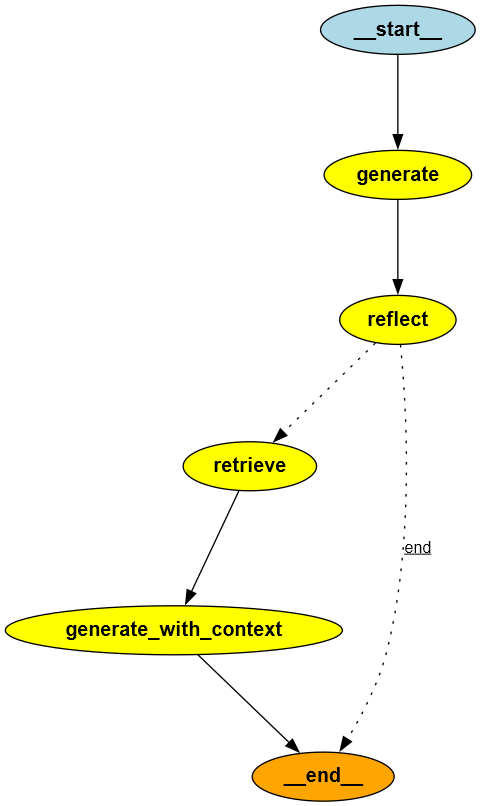

In [15]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_png()))

In [16]:
def run_self_rag(question: str, pdf_path: str = None):
    """Run the Self-RAG system with a question and optional PDF"""
    initial_state = AgentState(
        messages=[HumanMessage(content=question)],
        next_action="generate",
        retrieved_context="",
        reflection_score=0.0,
        pdf_path=pdf_path or ""
    )
    
    result = graph.invoke(initial_state)
    # Return the last AI message
    for message in reversed(result["messages"]):
        if isinstance(message, AIMessage):
            return message.content
    return "No response generated"

In [17]:
question = "Identify the the candidate technical ability and area in which he can contribute?"
answer =  run_self_rag(question=question, pdf_path="./Siddhartha.Sadhukhan_Resume.pdf")
print(f"Question: {question}")
print(f"Answer: {answer}")

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


Question: Identify the the candidate technical ability and area in which he can contribute?
Answer: <think>
Okay, the user wants to know the technical abilities and areas a candidate can contribute. But they didn't specify who the candidate is. Looking back at the context provided, there's a detailed resume of Siddhartha Sadhukhan. The user might have intended to ask about this candidate.

The resume mentions his experience in Product Development, working at Société Générale, expertise in Big Data technologies like Hadoop, Spark, Kafka, and cloud platforms like Azure. He also has skills in databases (Hive, Postgres), programming languages (Java, Python), and frameworks. His publications show work in image steganography and medical imaging, indicating research interests. His projects include PcRemote and Home Automation System, highlighting his hands-on experience with IoT and embedded systems.

So, the answer should focus on Siddhartha's technical skills and areas of contribution based